In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import create_model, pull_data, fit_give, estimate_population_uncertainty
from electronfactors.visuals.utilities import create_green_cm

In [2]:
green_cm = create_green_cm()

In [3]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)
rc('legend', fontsize=16, scatterpoints=1, fancybox=True)

In [22]:
def display_fit(width, eqPonA, factor, model):
    plt.figure(figsize=(6 * 1.618, 6))
    x = np.arange(np.floor(np.min(width)) - 0.5, np.ceil(np.max(width)) + 0.5, 0.01)
    y = np.arange(np.floor(np.min(eqPonA)*10)/10 - 0.2, np.ceil(np.max(eqPonA)*10)/10 + 0.2, 0.002)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    give = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)

    outOfTolerance = (give > 0.5)

    zz[outOfTolerance] = np.nan

    c = plt.contourf(xx, yy, zz, 100, alpha=1, cmap=green_cm)
    plt.colorbar(c, ticks=np.arange(0.93, 1.01, 0.01), label=r'Cutout factor prediction')

    plt.contour(xx, yy, give, levels=[0.5], colors='k')

    plt.scatter(width, eqPonA, s=100, alpha=0.9, 
                c='black', zorder=3, label=r'Measured data')

    plt.xlabel(r'Width (cm)')
    plt.ylabel(r'Perimeter / Area (cm$^{-1}$)')
    


In [23]:
width = np.array([ 3.16,  7.82,  5.34,  7.08,  6.08,  3.55,  5.25,  6.53])
eqPonA = np.array([ 1.02957848,  0.4429889 ,  0.59405193,  0.47320223,  0.63045757,
                    0.8513652 ,  0.76118069,  0.49620497])
factor = np.array([ 0.9348,  1.0019,  0.9934,  1.0052,  0.9933,  0.9443,  0.9705,
                    1.0004])

(3, 8.1)

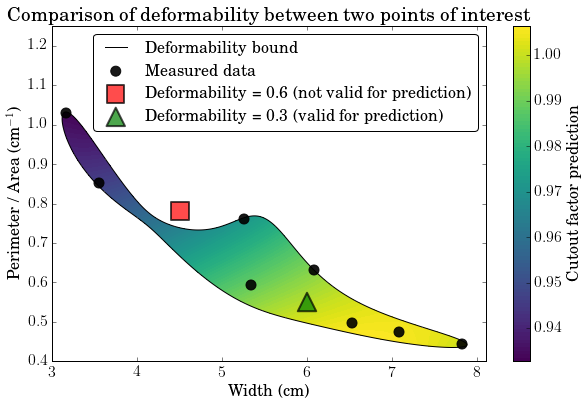

In [33]:
model = create_model(width, eqPonA, factor)
display_fit(width, eqPonA, factor, model)
plt.title(r'Comparison of deformability between two points of interest')
plt.scatter(4.5, 0.78, marker='s', lw=2,
            s=300, alpha=0.7, c='red', 
            label=r'Deformability = 0.6 (not valid for prediction)')
plt.scatter(6, 0.55, marker='^', lw=2,
            s=340, alpha=0.7, c='green', 
            label=r'Deformability = 0.3 (valid for prediction)')
plt.plot(3, 0.4, 'k-', label=r'Deformability bound')
legend = plt.legend(fancybox=True)
legend.get_frame().set_facecolor('white')

plt.ylim([0.4, 1.25])
plt.xlim([3, 8.1])

In [57]:
def display_fit_3D(width, eqPonA, factor, model):
    fig = plt.figure(figsize=(6 * 1.618, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    x = np.arange(np.floor(np.min(width)), np.ceil(np.max(width)), 0.05)
    y = np.arange(np.floor(np.min(eqPonA)*10)/10, np.ceil(np.max(eqPonA)*10)/10, 0.005)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    
    small = (zz < 0.8)
    zz[small] = 0.8
    ax.plot_surface(xx, yy, zz, rstride=5, cstride=5, alpha=0.8,
                    cmap=green_cm, lw=0.3, vmin=0.8, vmax=1.8)
    

    ax.scatter(width, eqPonA, factor, s=100, alpha=0.9, c='black', zorder=10)
    
    ax.set_zlim([0.8,2.5])

    plt.xlabel(r'Width (cm)')
    plt.ylabel(r'Perimeter / Area (cm$^{-1}$)')
    ax.set_zlabel(r'Cutout factor')
    
    return ax

In [47]:
pointA = model(4.5, 0.78)
pointB = model(6, 0.55)

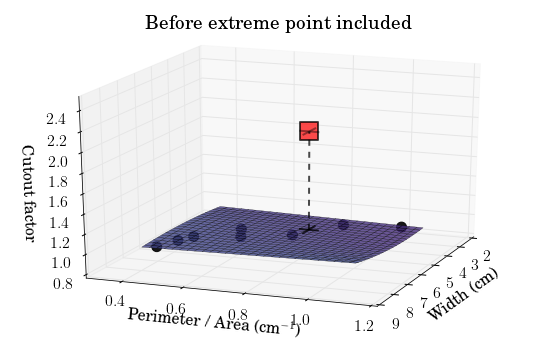

In [65]:
ax = display_fit_3D(width, eqPonA, factor, model)
plt.title(r'Before extreme point included')
ax.scatter(
    4.5, 0.78, pointA + 1, 
    marker='s', s=300, alpha=0.7, c='red',
    lw=2
)

ax.plot([4.5]*2, [0.75, 0.81], [pointA]*2, color='black', lw=2, alpha=0.7)
ax.plot([4.1, 4.9], [0.78]*2, [pointA]*2, color='black', lw=2, alpha=0.7)

ax.plot([4.5]*2, [0.75, 0.81], [pointA+1]*2, color='black', lw=2, alpha=0.4)
ax.plot([4.1, 4.9], [0.78]*2, [pointA+1]*2, color='black', lw=2, alpha=0.4)

ax.plot([4.5]*2, [0.78]*2, [pointA, pointA + 1], lw=2, color='black', ls='--', alpha=0.7)
ax.view_init(elev=20, azim=21)

0.6022515186310633

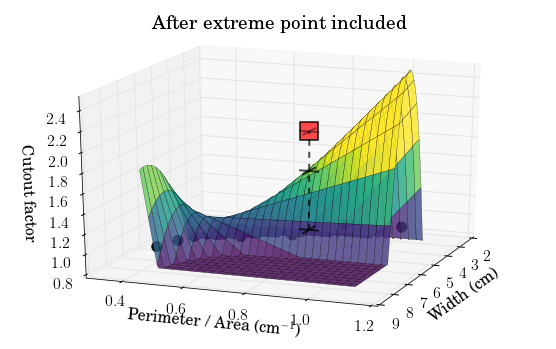

In [64]:
extreme_modelA = create_model(np.append(width, 4.5), np.append(eqPonA, 0.78), np.append(factor, pointA+1))
ax = display_fit_3D(width, eqPonA, factor, extreme_modelA)
ax.plot([4.5]*2, [0.78]*2, [pointA, pointA + 1], lw=2, color='black', ls='--', alpha=0.7)

plt.title(r'After extreme point included')
ax.plot([4.5]*2, [0.75, 0.81], [extreme_modelA(4.5, 0.78)]*2, color='black', lw=2, alpha=0.7)
ax.plot([4.1, 4.9], [0.78]*2, [extreme_modelA(4.5, 0.78)]*2, color='black', lw=2, alpha=0.7)

ax.plot([4.5]*2, [0.75, 0.81], [pointA]*2, color='black', lw=2, alpha=0.7)
ax.plot([4.1, 4.9], [0.78]*2, [pointA]*2, color='black', lw=2, alpha=0.7)

ax.plot([4.5]*2, [0.75, 0.81], [pointA+1]*2, color='black', lw=2, alpha=0.4)
ax.plot([4.1, 4.9], [0.78]*2, [pointA+1]*2, color='black', lw=2, alpha=0.4)

ax.scatter(4.5, 0.78, pointA + 1, marker='s', s=300, alpha=0.7, c='red', lw=2)

ax.view_init(elev=20, azim=21)

extreme_modelA(4.5, 0.78) - pointA

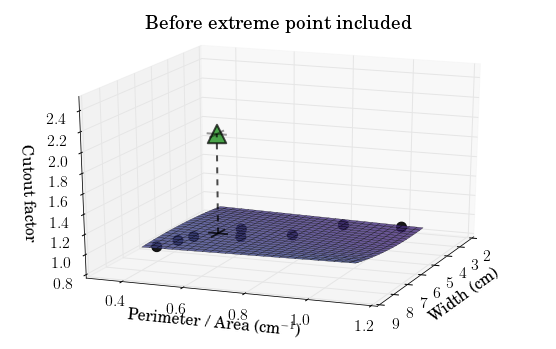

In [66]:
ax = display_fit_3D(width, eqPonA, factor, model)
plt.title(r'Before extreme point included')
ax.scatter(6, 0.55, pointB + 1, marker='^', s=340, alpha=0.7, c='green', lw=2)

ax.plot([6]*2, [0.52, 0.58], [pointB]*2, color='black', lw=2, alpha=0.7)
ax.plot([5.6, 6.4], [0.55]*2, [pointB]*2, color='black', lw=2, alpha=0.7)

ax.plot([6]*2, [0.52, 0.58], [pointB+1]*2, color='black', lw=2, alpha=0.4)
ax.plot([5.6, 6.4], [0.55]*2, [pointB+1]*2, color='black', lw=2, alpha=0.4)

ax.plot([6]*2, [0.55]*2, [pointB, pointB + 1], lw=2, color='black', ls='--', alpha=0.7)
ax.view_init(elev=20, azim=21)

0.28218384691447562

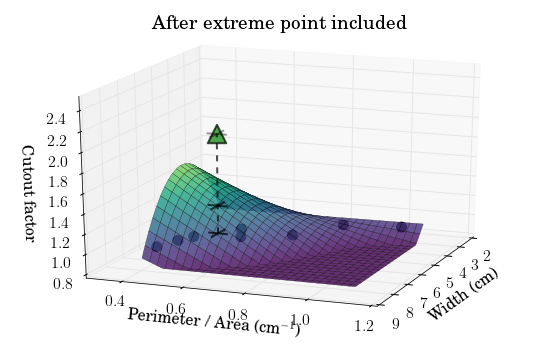

In [67]:
extreme_modelB = create_model(np.append(width, 6), np.append(eqPonA, 0.55), np.append(factor, pointB+1))
ax = display_fit_3D(width, eqPonA, factor, extreme_modelB)
plt.title(r'After extreme point included')
ax.scatter(6, 0.55, pointB + 1, marker='^', s=340, alpha=0.7, c='green', lw=2)
ax.plot([6]*2, [0.55]*2, [pointB, pointB + 1], lw=2, color='black', ls='--', alpha=0.7)

ax.plot([6]*2, [0.52, 0.58], [extreme_modelB(6, 0.55)]*2, color='black', lw=2, alpha=0.7)
ax.plot([5.6, 6.4], [0.55]*2, [extreme_modelB(6, 0.55)]*2, color='black', lw=2, alpha=0.7)

ax.plot([6]*2, [0.52, 0.58], [pointB]*2, color='black', lw=2, alpha=0.7)
ax.plot([5.6, 6.4], [0.55]*2, [pointB]*2, color='black', lw=2, alpha=0.7)

ax.plot([6]*2, [0.52, 0.58], [pointB+1]*2, color='black', lw=2, alpha=0.4)
ax.plot([5.6, 6.4], [0.55]*2, [pointB+1]*2, color='black', lw=2, alpha=0.4)
ax.view_init(elev=20, azim=21)

extreme_modelB(6, 0.55) - pointB